OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [385]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

### Introduction

#### Importing libraries

In [386]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time, strftime, gmtime
import pickle

import warnings
warnings.filterwarnings(action="ignore")

from exploration import *

from sklearn. model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [387]:
# Heure démarrage
t0 = time()

# seed pour les générateurs aléatoires
seed = 1
print("Seed value: ", seed)

Seed value:  1


#### Loading dataset

In [388]:
global columns_to_categorize
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]
category_types = {column: 'object' for column in columns_to_categorize}

path = "./dataset/cleaned/"
filename = "data_exploration.csv"
dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type

dataset = pd.read_csv(dataset_path, encoding='utf-8', dtype=category_types)

In [389]:
dataset.shape

(3147, 16)

In [390]:
dataset.dtypes

Neighborhood                            object
BuildingType                            object
PrimaryPropertyType                     object
ENERGYSTARScore                        float64
YearBuilt                                int64
Log-NumberofBuildings                  float64
Log-NumberofFloors                     float64
Log-PropertyGFATotal                   float64
Log-PropertyGFAParking                 float64
Log-SecondLargestPropertyUseTypeGFA    float64
Log-ThirdLargestPropertyUseTypeGFA     float64
Log-TotalEnergy(kBtu)                  float64
Log-SteamUse(kBtu)                     float64
Log-Electricity(kBtu)                  float64
Log-NaturalGas(kBtu)                   float64
Log-TotalGHGEmissions                  float64
dtype: object

In [391]:
dataset.columns

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'ENERGYSTARScore', 'YearBuilt', 'Log-NumberofBuildings',
       'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFAParking',
       'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA', 'Log-TotalEnergy(kBtu)',
       'Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)',
       'Log-TotalGHGEmissions'],
      dtype='object')

### 0) Separation common train and test dataset for CO2 and Energy predictions

In [392]:
# We create a training set and a test set (the test set contains 30% of the dataset)
train_common, test_common = train_test_split(dataset, test_size=0.3,  random_state=seed)

In [393]:
train_common

,Neighborhood,BuildingType,PrimaryPropertyType,ENERGYSTARScore,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalEnergy(kBtu),Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalGHGEmissions
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily,NaN,1997,0.693147,1.386294,10.727246,0.0,9.792444,7.848153,14.067857,0.0,14.067857,0.000000,2.299581
1784,North,Multifamily lr (1-4),Low-rise multifamily,75.0,1979,0.693147,1.098612,10.429783,0.0,6.240276,0.000000,13.734070,0.0,13.734069,0.000000,2.005526
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily,72.0,1988,0.693147,1.609438,10.120533,0.0,0.000000,0.000000,13.380600,0.0,13.380599,0.000000,1.706565
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office,91.0,1982,0.693147,1.791759,11.499526,0.0,0.000000,0.000000,15.295147,0.0,15.295147,0.000000,3.453474
1561,Downtown,Multifamily hr (10+),High-rise multifamily,67.0,1980,0.693147,2.944439,11.738139,0.0,9.063811,0.000000,15.389618,0.0,14.915060,14.416334,4.777357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily,NaN,1985,0.693147,1.791759,10.556620,0.0,0.000000,0.000000,14.117894,0.0,14.117894,0.000000,2.344686
905,Southwest,Nonresidential,Small- and mid-sized office,60.0,1981,0.693147,1.386294,10.677938,0.0,0.000000,0.000000,14.803849,0.0,14.671030,12.719411,3.559625
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily,38.0,1978,2.833213,1.386294,11.397167,0.0,8.752423,0.000000,14.907515,0.0,14.907515,0.000000,3.080992
235,Downtown,Nonresidential,Small- and mid-sized office,72.0,1906,0.693147,1.609438,11.059441,0.0,0.000000,0.000000,15.073534,0.0,14.702697,13.901848,4.328494


### 1) Preparing the datasets to predict CO2

#### 1.1) Selection of features

In [394]:
# liste des variables et étiquettes
model_CO2_target = ['Log-TotalGHGEmissions']
model_CO2_features = ['Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)', 'Log-TotalEnergy(kBtu)']
model_CO2 = model_CO2_features + model_CO2_target

In [395]:
model_CO2

['Log-SteamUse(kBtu)',
 'Log-Electricity(kBtu)',
 'Log-NaturalGas(kBtu)',
 'Log-TotalEnergy(kBtu)',
 'Log-TotalGHGEmissions']

#### 1.2) Separation train and test dataset


In [396]:
train_common

,Neighborhood,BuildingType,PrimaryPropertyType,ENERGYSTARScore,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalEnergy(kBtu),Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalGHGEmissions
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily,NaN,1997,0.693147,1.386294,10.727246,0.0,9.792444,7.848153,14.067857,0.0,14.067857,0.000000,2.299581
1784,North,Multifamily lr (1-4),Low-rise multifamily,75.0,1979,0.693147,1.098612,10.429783,0.0,6.240276,0.000000,13.734070,0.0,13.734069,0.000000,2.005526
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily,72.0,1988,0.693147,1.609438,10.120533,0.0,0.000000,0.000000,13.380600,0.0,13.380599,0.000000,1.706565
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office,91.0,1982,0.693147,1.791759,11.499526,0.0,0.000000,0.000000,15.295147,0.0,15.295147,0.000000,3.453474
1561,Downtown,Multifamily hr (10+),High-rise multifamily,67.0,1980,0.693147,2.944439,11.738139,0.0,9.063811,0.000000,15.389618,0.0,14.915060,14.416334,4.777357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily,NaN,1985,0.693147,1.791759,10.556620,0.0,0.000000,0.000000,14.117894,0.0,14.117894,0.000000,2.344686
905,Southwest,Nonresidential,Small- and mid-sized office,60.0,1981,0.693147,1.386294,10.677938,0.0,0.000000,0.000000,14.803849,0.0,14.671030,12.719411,3.559625
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily,38.0,1978,2.833213,1.386294,11.397167,0.0,8.752423,0.000000,14.907515,0.0,14.907515,0.000000,3.080992
235,Downtown,Nonresidential,Small- and mid-sized office,72.0,1906,0.693147,1.609438,11.059441,0.0,0.000000,0.000000,15.073534,0.0,14.702697,13.901848,4.328494


In [397]:
# Selection des variables pour modélisation CO2
train_CO2, test_CO2 = train_common[model_CO2], test_common[model_CO2]

In [398]:
train_CO2

,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),Log-TotalGHGEmissions
1008,0.0,14.067857,0.000000,14.067857,2.299581
1784,0.0,13.734069,0.000000,13.734070,2.005526
1563,0.0,13.380599,0.000000,13.380600,1.706565
452,0.0,15.295147,0.000000,15.295147,3.453474
1561,0.0,14.915060,14.416334,15.389618,4.777357
...,...,...,...,...,...
2763,0.0,14.117894,0.000000,14.117894,2.344686
905,0.0,14.671030,12.719411,14.803849,3.559625
1096,0.0,14.907515,0.000000,14.907515,3.080992
235,0.0,14.702697,13.901848,15.073534,4.328494


#### 1.3) Standardization of numerical variables

In [399]:
train_CO2[model_CO2_features]

,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu)
1008,0.0,14.067857,0.000000,14.067857
1784,0.0,13.734069,0.000000,13.734070
1563,0.0,13.380599,0.000000,13.380600
452,0.0,15.295147,0.000000,15.295147
1561,0.0,14.915060,14.416334,15.389618
...,...,...,...,...
2763,0.0,14.117894,0.000000,14.117894
905,0.0,14.671030,12.719411,14.803849
1096,0.0,14.907515,0.000000,14.907515
235,0.0,14.702697,13.901848,15.073534


In [400]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scaler_CO2 = StandardScaler().fit(train_CO2[model_CO2_features])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_CO2_std, test_CO2_std = train_CO2.copy(), test_CO2.copy()

train_CO2_std[model_CO2_features] = std_scaler_CO2.transform(train_CO2[model_CO2_features])
test_CO2_std[model_CO2_features] = std_scaler_CO2.transform(test_CO2[model_CO2_features])

In [401]:
print("Before")
display(train_CO2)
print("After")
display(train_CO2_std)

Before


,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),Log-TotalGHGEmissions
1008,0.0,14.067857,0.000000,14.067857,2.299581
1784,0.0,13.734069,0.000000,13.734070,2.005526
1563,0.0,13.380599,0.000000,13.380600,1.706565
452,0.0,15.295147,0.000000,15.295147,3.453474
1561,0.0,14.915060,14.416334,15.389618,4.777357
...,...,...,...,...,...
2763,0.0,14.117894,0.000000,14.117894,2.344686
905,0.0,14.671030,12.719411,14.803849,3.559625
1096,0.0,14.907515,0.000000,14.907515,3.080992
235,0.0,14.702697,13.901848,15.073534,4.328494


After


,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),Log-TotalGHGEmissions
1008,-0.188172,-0.086626,-1.277697,-0.459330,2.299581
1784,-0.188172,-0.353593,-1.277697,-0.750107,2.005526
1563,-0.188172,-0.636303,-1.277697,-1.058031,1.706565
452,-0.188172,0.894976,-1.277697,0.609820,3.453474
1561,-0.188172,0.590977,0.875898,0.692118,4.777357
...,...,...,...,...,...
2763,-0.188172,-0.046605,-1.277697,-0.415740,2.344686
905,-0.188172,0.395799,0.622402,0.181827,3.559625
1096,-0.188172,0.584943,-1.277697,0.272136,3.080992
235,-0.188172,0.421127,0.799041,0.416763,4.328494


#### 1.4) Distribution of variables

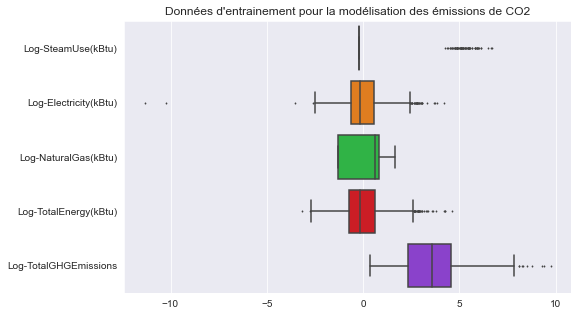

In [402]:
# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(8,5))
plt.title('Données d\'entrainement pour la modélisation des émissions de CO2')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_CO2_std), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

#### 1.5) Saving dataset

In [403]:
# Sauvegarde des jeux de données
train_CO2_std.to_csv("{}{}".format(path, "/CO2/train_CO2.csv"), encoding='utf-8', index=False)
test_CO2_std.to_csv("{}{}".format(path, "/CO2/test_CO2.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_CO2, 'scaler_features': model_CO2_features}
filename = 'model/scaler_CO2.sav'
pickle.dump(model, open(filename, 'wb'))

### 2) Preparation of the dataset to predict CO2 with EnergyStarScore

#### 2.1) Selection of features

In [404]:
# Liste des variables et étiquettes pour la modélisation
model_EnergyStarScore_target = ['Log-TotalGHGEmissions']
model_EnergyStarScore_features = model_CO2_features + ['ENERGYSTARScore']
model_EnergyStarScore = model_EnergyStarScore_features + model_EnergyStarScore_target

In [405]:
model_EnergyStarScore

['Log-SteamUse(kBtu)',
 'Log-Electricity(kBtu)',
 'Log-NaturalGas(kBtu)',
 'Log-TotalEnergy(kBtu)',
 'ENERGYSTARScore',
 'Log-TotalGHGEmissions']

#### 2.2) Separation train and test dataset


In [406]:
# we drop the buildings for which the EnergyStarScore is missing
dataset_clean = dataset.dropna(axis=0)

train_clean, test_clean = train_test_split(dataset_clean, test_size=0.3, random_state=seed)

In [407]:
# Selection des variables pour modélisation CO2
train_EnergyStarScore, test_EnergyStarScore = train_clean[model_EnergyStarScore], test_clean[model_EnergyStarScore]

In [408]:
train_EnergyStarScore

,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),ENERGYSTARScore,Log-TotalGHGEmissions
925,0.0,14.168931,0.000000,14.168931,70.0,2.391511
2759,0.0,13.104645,0.000000,13.104645,94.0,1.486140
460,0.0,16.513928,0.000000,16.513928,56.0,4.649857
670,0.0,13.761022,12.425317,13.994489,13.0,3.036394
161,0.0,15.139133,0.000000,15.139133,61.0,3.302849
...,...,...,...,...,...,...
1294,0.0,12.255881,13.949518,14.118288,88.0,4.146146
1228,0.0,12.746171,13.169155,13.673008,95.0,3.441059
1466,0.0,12.534041,12.398283,13.161609,89.0,2.760643
319,0.0,15.909429,13.190357,15.973282,89.0,4.454464


In [409]:
test_EnergyStarScore

,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),ENERGYSTARScore,Log-TotalGHGEmissions
959,0.0,12.384097,0.000000,12.384096,77.0,0.982078
266,0.0,14.935070,0.000000,14.935070,95.0,3.107274
999,0.0,12.798136,0.000000,12.798137,99.0,1.258461
1156,0.0,13.676978,0.000000,13.676978,40.0,1.955860
2031,0.0,12.780374,13.381648,13.818683,98.0,3.634687
...,...,...,...,...,...,...
761,0.0,14.140893,0.000000,14.140893,77.0,2.365560
2127,0.0,13.999316,0.000000,13.999316,54.0,2.238580
132,0.0,14.330220,14.738348,15.248109,34.0,4.985728
2426,0.0,12.912385,14.584986,14.757053,76.0,4.774660


#### 2.3) Standardization of numerical variables

In [410]:
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_EnergyStarScore_std, test_EnergyStarScore_std = train_EnergyStarScore.copy(), test_EnergyStarScore.copy()

std_scaler_EnergyStarScore = StandardScaler() # other way of writing the scaling
train_EnergyStarScore_std[model_EnergyStarScore_features] = std_scaler_EnergyStarScore.fit_transform(train_EnergyStarScore[model_EnergyStarScore_features])

test_EnergyStarScore_std[model_EnergyStarScore_features] = std_scaler_EnergyStarScore.transform(test_EnergyStarScore[model_EnergyStarScore_features])

In [411]:
train_EnergyStarScore_std

,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu),ENERGYSTARScore,Log-TotalGHGEmissions
925,-0.19772,-0.010690,-1.241644,-0.380561,0.084009,2.391511
2759,-0.19772,-0.923739,-1.241644,-1.347613,0.978844,1.486140
460,-0.19772,2.001079,-1.241644,1.750193,-0.437978,4.649857
670,-0.19772,-0.360635,0.606150,-0.539066,-2.041224,3.036394
161,-0.19772,0.821645,-1.241644,0.501002,-0.251554,3.302849
...,...,...,...,...,...,...
1294,-0.19772,-1.651892,0.832817,-0.426578,0.755135,4.146146
1228,-0.19772,-1.231273,0.716767,-0.831177,1.016128,3.441059
1466,-0.19772,-1.413259,0.602129,-1.295854,0.792420,2.760643
319,-0.19772,1.482480,0.719920,1.258942,0.792420,4.454464


#### 2.4) Distribution of variables

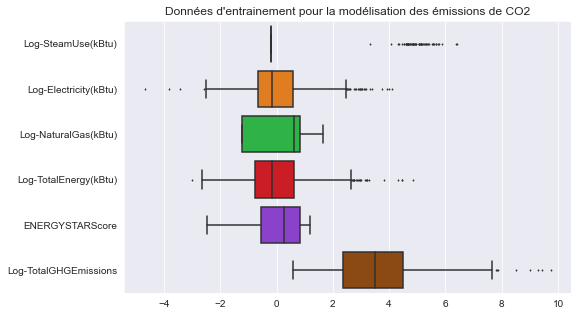

In [412]:
# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(8,5))
plt.title('Données d\'entrainement pour la modélisation des émissions de CO2')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_EnergyStarScore_std), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

#### 2.5) Saving dataset

In [413]:
# Sauvegarde des jeux de données
train_EnergyStarScore_std.to_csv("{}{}".format(path, "/CO2_EnergyStarScore/train_EnergyStarScore.csv"), encoding='utf-8', index=False)
test_EnergyStarScore_std.to_csv("{}{}".format(path, "/CO2_EnergyStarScore/test_EnergyStarScore.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_EnergyStarScore, 'scaler_features': model_EnergyStarScore_features}
filename = 'model/scaler_EnergyStarScore.sav'
pickle.dump(model, open(filename, 'wb'))

### 3) Preparation of the dataset to predict energy use

#### 3.1) Selection of features

In [414]:
dataset.columns

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'ENERGYSTARScore', 'YearBuilt', 'Log-NumberofBuildings',
       'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFAParking',
       'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA', 'Log-TotalEnergy(kBtu)',
       'Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)',
       'Log-TotalGHGEmissions'],
      dtype='object')

In [415]:
# Liste des variables et étiquettes
models_energy_target = model_CO2_features
models_energy_features = [feature for feature in dataset.columns if feature not in ['ENERGYSTARScore', *model_CO2_target, *model_CO2_features]]
models_energy = models_energy_features + models_energy_target

In [416]:
models_energy

['Neighborhood',
 'BuildingType',
 'PrimaryPropertyType',
 'YearBuilt',
 'Log-NumberofBuildings',
 'Log-NumberofFloors',
 'Log-PropertyGFATotal',
 'Log-PropertyGFAParking',
 'Log-SecondLargestPropertyUseTypeGFA',
 'Log-ThirdLargestPropertyUseTypeGFA',
 'Log-SteamUse(kBtu)',
 'Log-Electricity(kBtu)',
 'Log-NaturalGas(kBtu)',
 'Log-TotalEnergy(kBtu)']

#### 3.2) Separation train and test dataset

In [417]:
# Selection des variables pour modélisation CO2
train_energy, test_energy = train_common[models_energy], test_common[models_energy]

In [418]:
train_energy

,Neighborhood,BuildingType,PrimaryPropertyType,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu)
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily,1997,0.693147,1.386294,10.727246,0.0,9.792444,7.848153,0.0,14.067857,0.000000,14.067857
1784,North,Multifamily lr (1-4),Low-rise multifamily,1979,0.693147,1.098612,10.429783,0.0,6.240276,0.000000,0.0,13.734069,0.000000,13.734070
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily,1988,0.693147,1.609438,10.120533,0.0,0.000000,0.000000,0.0,13.380599,0.000000,13.380600
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office,1982,0.693147,1.791759,11.499526,0.0,0.000000,0.000000,0.0,15.295147,0.000000,15.295147
1561,Downtown,Multifamily hr (10+),High-rise multifamily,1980,0.693147,2.944439,11.738139,0.0,9.063811,0.000000,0.0,14.915060,14.416334,15.389618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily,1985,0.693147,1.791759,10.556620,0.0,0.000000,0.000000,0.0,14.117894,0.000000,14.117894
905,Southwest,Nonresidential,Small- and mid-sized office,1981,0.693147,1.386294,10.677938,0.0,0.000000,0.000000,0.0,14.671030,12.719411,14.803849
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily,1978,2.833213,1.386294,11.397167,0.0,8.752423,0.000000,0.0,14.907515,0.000000,14.907515
235,Downtown,Nonresidential,Small- and mid-sized office,1906,0.693147,1.609438,11.059441,0.0,0.000000,0.000000,0.0,14.702697,13.901848,15.073534


#### 3.3) Normalization

In [419]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [420]:
dataset.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = dataset.select_dtypes(['category','object']).columns
numerical_columns = dataset[models_energy_features].select_dtypes(include='number').columns.drop("YearBuilt") ###
#numerical_columns = X.select_dtypes(include='number').columns
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (3,)
Shape of numerical variables : (6,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [421]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 6 numerical features to standardize.

Index(['Log-NumberofBuildings', 'Log-NumberofFloors', 'Log-PropertyGFATotal',
       'Log-PropertyGFAParking', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [422]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scaler_energy = StandardScaler().fit(train_energy[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_energy_std, test_energy_std = train_energy.copy(), test_energy.copy()

train_energy_std[numerical_columns] = std_scaler_energy.transform(train_energy[numerical_columns])
test_energy_std[numerical_columns] = std_scaler_energy.transform(test_energy[numerical_columns])

print("Before")
display(train_energy)
print("After")
display(train_energy_std)

Before


,Neighborhood,BuildingType,PrimaryPropertyType,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu)
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily,1997,0.693147,1.386294,10.727246,0.0,9.792444,7.848153,0.0,14.067857,0.000000,14.067857
1784,North,Multifamily lr (1-4),Low-rise multifamily,1979,0.693147,1.098612,10.429783,0.0,6.240276,0.000000,0.0,13.734069,0.000000,13.734070
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily,1988,0.693147,1.609438,10.120533,0.0,0.000000,0.000000,0.0,13.380599,0.000000,13.380600
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office,1982,0.693147,1.791759,11.499526,0.0,0.000000,0.000000,0.0,15.295147,0.000000,15.295147
1561,Downtown,Multifamily hr (10+),High-rise multifamily,1980,0.693147,2.944439,11.738139,0.0,9.063811,0.000000,0.0,14.915060,14.416334,15.389618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily,1985,0.693147,1.791759,10.556620,0.0,0.000000,0.000000,0.0,14.117894,0.000000,14.117894
905,Southwest,Nonresidential,Small- and mid-sized office,1981,0.693147,1.386294,10.677938,0.0,0.000000,0.000000,0.0,14.671030,12.719411,14.803849
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily,1978,2.833213,1.386294,11.397167,0.0,8.752423,0.000000,0.0,14.907515,0.000000,14.907515
235,Downtown,Nonresidential,Small- and mid-sized office,1906,0.693147,1.609438,11.059441,0.0,0.000000,0.000000,0.0,14.702697,13.901848,15.073534


After


,Neighborhood,BuildingType,PrimaryPropertyType,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu)
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily,1997,-0.035067,-0.287309,-0.238103,-0.405348,1.108652,1.972318,0.0,14.067857,0.000000,14.067857
1784,North,Multifamily lr (1-4),Low-rise multifamily,1979,-0.035067,-0.782088,-0.582698,-0.405348,0.371487,-0.439239,0.0,13.734069,0.000000,13.734070
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily,1988,-0.035067,0.096471,-0.940947,-0.405348,-0.923528,-0.439239,0.0,13.380599,0.000000,13.380600
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office,1982,-0.035067,0.410042,0.656541,-0.405348,-0.923528,-0.439239,0.0,15.295147,0.000000,15.295147
1561,Downtown,Multifamily hr (10+),High-rise multifamily,1980,-0.035067,2.392512,0.932961,-0.405348,0.957442,-0.439239,0.0,14.915060,14.416334,15.389618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily,1985,-0.035067,0.410042,-0.435764,-0.405348,-0.923528,-0.439239,0.0,14.117894,0.000000,14.117894
905,Southwest,Nonresidential,Small- and mid-sized office,1981,-0.035067,-0.287309,-0.295223,-0.405348,-0.923528,-0.439239,0.0,14.671030,12.719411,14.803849
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily,1978,10.208154,-0.287309,0.537964,-0.405348,0.892821,-0.439239,0.0,14.907515,0.000000,14.907515
235,Downtown,Nonresidential,Small- and mid-sized office,1906,-0.035067,0.096471,0.146726,-0.405348,-0.923528,-0.439239,0.0,14.702697,13.901848,15.073534


##### 2) Feature Encoding : One Hot Encoder

In [423]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType'], dtype='object')


In [424]:
train_energy.dtypes # we check that we have categories

Neighborhood                            object
BuildingType                            object
PrimaryPropertyType                     object
YearBuilt                                int64
Log-NumberofBuildings                  float64
Log-NumberofFloors                     float64
Log-PropertyGFATotal                   float64
Log-PropertyGFAParking                 float64
Log-SecondLargestPropertyUseTypeGFA    float64
Log-ThirdLargestPropertyUseTypeGFA     float64
Log-SteamUse(kBtu)                     float64
Log-Electricity(kBtu)                  float64
Log-NaturalGas(kBtu)                   float64
Log-TotalEnergy(kBtu)                  float64
dtype: object

In [425]:
train_energy[categorical_columns].nunique()

Neighborhood           13
BuildingType            7
PrimaryPropertyType    23
dtype: int64

In [426]:
train_energy_std[categorical_columns]

,Neighborhood,BuildingType,PrimaryPropertyType
1008,Northeast,Multifamily lr (1-4),Low-rise multifamily
1784,North,Multifamily lr (1-4),Low-rise multifamily
1563,Lake union,Multifamily lr (1-4),Low-rise multifamily
452,Magnolia / queen anne,Nonresidential,Small- and mid-sized office
1561,Downtown,Multifamily hr (10+),High-rise multifamily
...,...,...,...
2763,East,Multifamily mr (5-9),Mid-rise multifamily
905,Southwest,Nonresidential,Small- and mid-sized office
1096,Northwest,Multifamily lr (1-4),Low-rise multifamily
235,Downtown,Nonresidential,Small- and mid-sized office


##### Encoding the categorical features of the train set


In [427]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([train_energy[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 43 columns to encodes the categorical features.


In [428]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(train_energy_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(train_energy_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=train_energy_std.index)
display(train_encoded.sort_index())

We have indeed : 43 labels after encoding the categorical variables.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
# 5) Concatenate the two dataframes for the training set

print("We need to add YearBuilt to the list of features.")
numerical_columns.tolist()
features_to_merge = numerical_columns.tolist().copy()
features_to_merge.append("YearBuilt")
features_to_merge.extend(models_energy_target)###
print(features_to_merge, end="\n\n")

print("ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??")
train_std_encoded = pd.merge(train_energy_std[features_to_merge].sort_index(), train_encoded.sort_index(), left_index=True, right_index=True)
display(train_std_encoded.sort_index())

We need to add YearBuilt to the list of features.
['Log-NumberofBuildings', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFAParking', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'YearBuilt', 'Log-SteamUse(kBtu)', 'Log-Electricity(kBtu)', 'Log-NaturalGas(kBtu)', 'Log-TotalEnergy(kBtu)']

ASK JEREMY : merge based on index ok ? or should I put back OSEBuildingID ??


,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,-0.035067,1.739835,0.529688,-0.405348,-0.923528,-0.439239,1927,14.510597,15.188220,14.059596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.035067,1.602172,0.712666,2.274807,1.072892,2.153810,1996,0.000000,14.991964,15.453552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.035067,3.756773,3.287491,2.990638,-0.923528,-0.439239,1969,16.886654,17.718022,14.216834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.035067,-0.782088,0.640225,2.526634,-0.923528,-0.439239,1999,0.000000,15.813123,15.366298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.035067,1.107393,0.703626,-0.405348,-0.923528,-0.439239,1926,14.638056,15.106575,12.861492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,-0.035067,0.096471,-0.349445,-0.405348,0.841584,-0.439239,2015,0.000000,13.513113,12.975567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3139,-0.035067,-0.287309,-0.913535,1.379140,0.866893,2.071010,2015,0.000000,13.679047,14.085077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3140,-0.035067,0.904820,0.151911,1.959102,-0.923528,-0.439239,2015,0.000000,14.223590,13.633661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3141,-0.035067,0.904820,2.037475,-0.405348,-0.923528,-0.439239,2015,0.000000,15.991918,15.850596,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Encoding the categorical features of the test set

In [430]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(test_energy_std[categorical_columns])

# 5.2) we recreate a dataframe with the column names and the numpy array
test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=test_energy_std.index)
display(test_encoded.sort_index())

test_std_encoded = pd.merge(test_energy_std[features_to_merge].sort_index(), test_encoded.sort_index(), left_index=True, right_index=True)
display(test_std_encoded.sort_index())

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3142,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3143,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
3,-0.035067,1.452522,0.105529,-0.405348,-0.923528,-0.439239,1926,14.610513,14.833970,14.409508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.035067,2.392512,1.324188,2.668961,1.385691,-0.439239,1980,0.000000,15.496079,15.990717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.035067,1.602172,0.456337,-0.405348,-0.923528,-0.439239,1926,0.000000,14.849128,14.896495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-0.035067,1.602172,1.165954,2.343535,-0.923528,-0.439239,1969,15.471291,15.638062,15.339794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.035067,1.288600,0.173204,-0.405348,-0.923528,-0.439239,1928,14.320129,14.110417,15.095529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,-0.035067,0.904820,1.553162,2.618557,1.527976,-0.439239,2015,0.000000,14.946797,15.057593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3142,-0.035067,0.675162,0.497963,2.128455,0.944811,1.780089,2015,0.000000,14.586193,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3143,-0.035067,0.675162,2.107630,2.756954,1.478762,3.044854,2015,0.000000,16.978316,16.570909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3144,-0.035067,0.904820,1.521235,2.654283,1.298680,-0.439239,2015,0.000000,14.503028,14.262382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [431]:
print("We can start now the modelling to predict the feature wanted.")

display(train_std_encoded)
display(test_std_encoded)

We can start now the modelling to predict the feature wanted.


,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,-0.035067,1.739835,0.529688,-0.405348,-0.923528,-0.439239,1927,14.510597,15.188220,14.059596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.035067,1.602172,0.712666,2.274807,1.072892,2.153810,1996,0.000000,14.991964,15.453552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.035067,3.756773,3.287491,2.990638,-0.923528,-0.439239,1969,16.886654,17.718022,14.216834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.035067,-0.782088,0.640225,2.526634,-0.923528,-0.439239,1999,0.000000,15.813123,15.366298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.035067,1.107393,0.703626,-0.405348,-0.923528,-0.439239,1926,14.638056,15.106575,12.861492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,-0.035067,0.096471,-0.349445,-0.405348,0.841584,-0.439239,2015,0.000000,13.513113,12.975567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3139,-0.035067,-0.287309,-0.913535,1.379140,0.866893,2.071010,2015,0.000000,13.679047,14.085077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3140,-0.035067,0.904820,0.151911,1.959102,-0.923528,-0.439239,2015,0.000000,14.223590,13.633661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3141,-0.035067,0.904820,2.037475,-0.405348,-0.923528,-0.439239,2015,0.000000,15.991918,15.850596,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
3,-0.035067,1.452522,0.105529,-0.405348,-0.923528,-0.439239,1926,14.610513,14.833970,14.409508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.035067,2.392512,1.324188,2.668961,1.385691,-0.439239,1980,0.000000,15.496079,15.990717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.035067,1.602172,0.456337,-0.405348,-0.923528,-0.439239,1926,0.000000,14.849128,14.896495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-0.035067,1.602172,1.165954,2.343535,-0.923528,-0.439239,1969,15.471291,15.638062,15.339794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,-0.035067,1.288600,0.173204,-0.405348,-0.923528,-0.439239,1928,14.320129,14.110417,15.095529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,-0.035067,0.904820,1.553162,2.618557,1.527976,-0.439239,2015,0.000000,14.946797,15.057593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3142,-0.035067,0.675162,0.497963,2.128455,0.944811,1.780089,2015,0.000000,14.586193,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3143,-0.035067,0.675162,2.107630,2.756954,1.478762,3.044854,2015,0.000000,16.978316,16.570909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3144,-0.035067,0.904820,1.521235,2.654283,1.298680,-0.439239,2015,0.000000,14.503028,14.262382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [433]:
print("We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.")
train_energy_preprocess = train_std_encoded.copy()
test_energy_preprocess = test_std_encoded.copy()

train_energy_preprocess

We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.


,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,YearBuilt,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,-0.035067,1.739835,0.529688,-0.405348,-0.923528,-0.439239,1927,14.510597,15.188220,14.059596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.035067,1.602172,0.712666,2.274807,1.072892,2.153810,1996,0.000000,14.991964,15.453552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.035067,3.756773,3.287491,2.990638,-0.923528,-0.439239,1969,16.886654,17.718022,14.216834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-0.035067,-0.782088,0.640225,2.526634,-0.923528,-0.439239,1999,0.000000,15.813123,15.366298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.035067,1.107393,0.703626,-0.405348,-0.923528,-0.439239,1926,14.638056,15.106575,12.861492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,-0.035067,0.096471,-0.349445,-0.405348,0.841584,-0.439239,2015,0.000000,13.513113,12.975567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3139,-0.035067,-0.287309,-0.913535,1.379140,0.866893,2.071010,2015,0.000000,13.679047,14.085077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3140,-0.035067,0.904820,0.151911,1.959102,-0.923528,-0.439239,2015,0.000000,14.223590,13.633661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3141,-0.035067,0.904820,2.037475,-0.405348,-0.923528,-0.439239,2015,0.000000,15.991918,15.850596,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3.4) Distribution of variables

We can check that the numerical variables have a Standard Normal distribution.
___Density distribution___


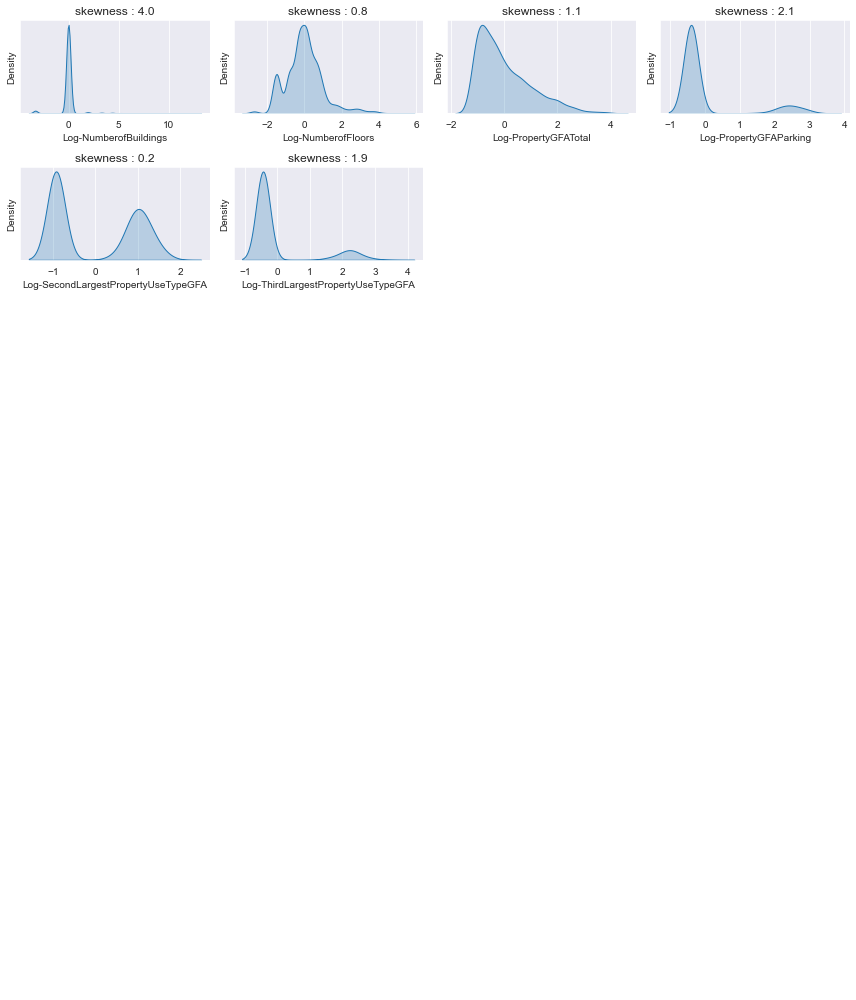

In [434]:
print("We can check that the numerical variables have a Standard Normal distribution.")
density(train_energy_preprocess[numerical_columns])

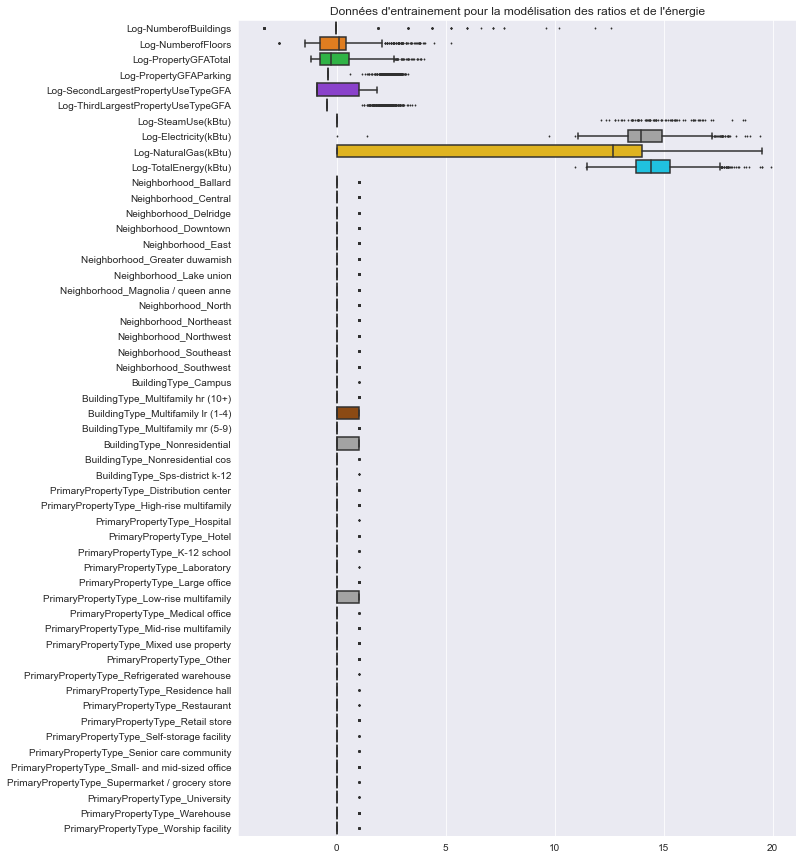

In [435]:
train_plot = train_energy_preprocess.drop(columns="YearBuilt")

# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(10,15))
plt.title('Données d\'entrainement pour la modélisation des ratios et de l\'énergie')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_plot), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

#### 3.5) Saving dataset

In [436]:
numerical_columns

Index(['Log-NumberofBuildings', 'Log-NumberofFloors', 'Log-PropertyGFATotal',
       'Log-PropertyGFAParking', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [437]:
# Sauvegarde des jeux de données
train_energy_preprocess.to_csv("{}{}".format(path, "/energy/train_energy.csv"), encoding='utf-8', index=False)
test_energy_preprocess.to_csv("{}{}".format(path, "/energy/test_energy.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_energy, 'scaler_features': numerical_columns.tolist(), 'encoder': one_hot_encoder, 'encoder_features': categorical_columns.tolist()}
filename = 'model/scaler_encoder_energy.sav'
pickle.dump(model, open(filename, 'wb'))

In [438]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 6.907401 sec
computing time : 00:00:06
